Code adapted from https://github.com/patrickcgray/open-geo-tutorial

In [55]:
from IPython.display import Audio, display
from timeit import default_timer as timer
start = timer()
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
def alert():
  global start
  end= timer()
  print("\n\nDuration in minutes : " +  str((end - start)/60) + " minutes." )
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

# Preparing Dataset

#### Cutting images for faster process

In [56]:
# 0 to  10980 for this img_data
#training
#xmin = 6700
#xmax = 6900
#ymin = 6700
#ymax = 6900
xmin = 6700
xmax = 7000
ymin = 6600
ymax = 6900
xmin_test = 6500
xmax_test = 6700
ymin_test = 6750
ymax_test = 6950

shapemin = min(xmin,ymin,xmin_test,ymin_test)
shapemax = max(xmax,ymax,xmax_test,ymax_test)
print(shapemin)
shapemax

6500


7000

In [57]:
import rasterio
from rasterio.mask import mask
import geopandas as gp
import numpy as np
import shapely
from shapely import geometry
from shapely.geometry import shape, Point, LineString, Polygon , mapping
import matplotlib.pyplot as plt
from rasterio.plot import show
import pyproj
from pyproj import CRS
import fiona
import os # we need os to do some basic file operations
import re
from rasterio.plot import adjust_band
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt
from rasterio.plot import show
from pyproj import transform
from pyproj import Proj
import ast

In [58]:
# create a products directory within the data dir which won't be uploaded to Github
img_dir = './data/'

# check to see if the dir it exists, if not, create it
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# filepath for image we're writing out
img_fp = img_dir + 'sentinel_bands_img_data_1.tif'

In [59]:
full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape) # dimensions
print(full_dataset.count) # bands

(10980, 10980)
4


In [60]:
with rasterio.open(img_fp) as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()[:,  :  ,   :  ]

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification


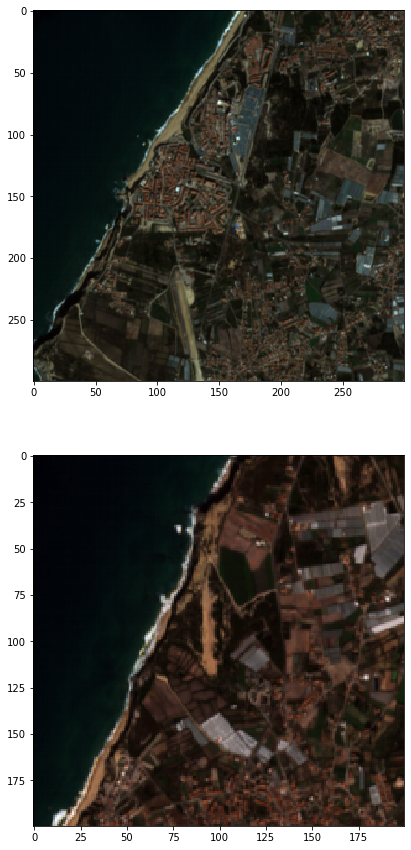

In [61]:
img_train = img[:, xmin : xmax ,  ymin : ymax ]
img_test = img[:, xmin_test : xmax_test ,  ymin_test : ymax_test ]
reshaped_img_train = reshape_as_image(img_train)
reshaped_img_test = reshape_as_image(img_test)

fig, axs = plt.subplots(2,1,figsize=(15,15))
img_stretched_train = color_stretch(reshaped_img_train, [2, 1, 0])
axs[0].imshow(img_stretched_train)

img_stretched_test = color_stretch(reshaped_img_test, [2, 1, 0])
axs[1].imshow(img_stretched_test)

# Intercepting label data with cutting image

In [62]:
# Open the dataset from the file
shapefile = gp.read_file('./data/shapefiles/shapefile_compressed/shp_2012_IMG_DATA_1.shp')
shapefile = shapefile.filter(['Legenda','geometry','CLC2012'])
shapefile.crs = {'init': 'epsg:4326'}

In [63]:
shapefile

,Legenda,geometry,CLC2012
0,Tecido urbano contínuo,"POLYGON ((-9.27768 38.76588, -9.27746 38.76555...",111
1,Tecido urbano contínuo,"POLYGON ((-9.25850 38.76457, -9.25850 38.76158...",111
2,Tecido urbano contínuo,"POLYGON ((-9.21069 38.76698, -9.21064 38.76633...",111
3,Tecido urbano contínuo,"POLYGON ((-9.22487 38.76998, -9.22474 38.76907...",111
4,Tecido urbano contínuo,"POLYGON ((-9.15237 38.77167, -9.15397 38.77135...",111
...,...,...,...
2606,Planos de água,"POLYGON ((-9.30538 39.32667, -9.30438 39.32591...",512
2607,Planos de água,"POLYGON ((-9.12876 39.36121, -9.12819 39.36034...",512
2608,Lagoas costeiras,"POLYGON ((-9.22812 39.43133, -9.22765 39.43071...",521
2609,Desembocaduras fluviais,"POLYGON ((-8.99046 38.92315, -8.99021 38.92267...",522


In [64]:
shapefile.bounds

,minx,miny,maxx,maxy
0,-9.290231,38.748262,-9.271269,38.765971
1,-9.269420,38.756289,-9.258351,38.767022
2,-9.223762,38.765308,-9.210637,38.771348
3,-9.259214,38.740093,-9.205557,38.772182
4,-9.155668,38.771354,-9.148402,38.778720
...,...,...,...,...
2606,-9.317734,39.321207,-9.299920,39.333992
2607,-9.137997,39.352063,-9.108531,39.362436
2608,-9.236594,39.385820,-9.183275,39.431828
2609,-9.323687,38.603732,-8.908901,38.937196


In [65]:
from pyproj import transform
from pyproj import Proj
def cut_bounds( xmin , xmax ,  ymin , ymax ):
    # this will get our four corner points
    xmin = xmin 
    ymin = ymin
    xmax = xmax
    ymax = ymax
    raster_gps_points = full_dataset.transform * (xmin, ymin),full_dataset.transform * (xmax, ymin),full_dataset.transform * (xmax, ymax), full_dataset.transform * (xmin, ymax),
    # Project all longitudes, latitudes using the pyproj package
    p1 = Proj(full_dataset.crs) # our current crs
    print(p1)
    print('raster bounds in current crs :\n', raster_gps_points)
    return raster_gps_points
raster_gps_points = cut_bounds( shapemin , shapemax ,  shapemin , shapemax )

Proj('+proj=utm +zone=29 +datum=WGS84 +units=m +no_defs', preserve_units=True)
raster bounds in current crs :
 ((464960.0, 4335040.0), (469960.0, 4335040.0), (469960.0, 4330040.0), (464960.0, 4330040.0))


In [66]:
def shapefile_from_rasterbounds(raster_gps_points,shapefile) :
    polygon = Polygon( list(raster_gps_points))
    print("Polygon raster gps points",polygon)
    imageBounds = gp.GeoDataFrame(crs=CRS.from_epsg(32629))
    imageBounds.geometry = [polygon]
    imageBounds = imageBounds.to_crs(fiona.crs.from_epsg(4326))
    print("Imaged cutted bounds",imageBounds.bounds)
    shapefile = shapefile.to_crs(fiona.crs.from_epsg(4326))
    print("Shapefile bounds",shapefile.bounds)
    intersected = gp.sjoin( shapefile, imageBounds, how='inner', op='intersects', lsuffix='left', rsuffix='right')
    intersected = intersected.reset_index()
    print("Intersected df",intersected)
    print("Intersected crs",intersected.crs)
    print("Intersected bounds",intersected.bounds)
    return intersected
shapefile = shapefile_from_rasterbounds(raster_gps_points,shapefile)

Polygon raster gps points POLYGON ((464960 4335040, 469960 4335040, 469960 4330040, 464960 4330040, 464960 4335040))


C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Imaged cutted bounds        minx       miny      maxx       maxy
0 -9.405594  39.118815 -9.347498  39.164057
Shapefile bounds           minx       miny      maxx       maxy
0    -9.290231  38.748262 -9.271269  38.765971
1    -9.269420  38.756289 -9.258351  38.767022
2    -9.223762  38.765308 -9.210637  38.771348
3    -9.259214  38.740093 -9.205557  38.772182
4    -9.155668  38.771354 -9.148402  38.778720
...        ...        ...       ...        ...
2606 -9.317734  39.321207 -9.299920  39.333992
2607 -9.137997  39.352063 -9.108531  39.362436
2608 -9.236594  39.385820 -9.183275  39.431828
2609 -9.323687  38.603732 -8.908901  38.937196
2610 -9.792798  36.730845 -7.206483  41.879798

[2611 rows x 4 columns]


C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


Intersected df     index                                           Legenda  \
0      33                            Tecido urbano contínuo   
1     247                         Tecido urbano descontínuo   
2     255                         Tecido urbano descontínuo   
3     679                  Culturas temporárias de sequeiro   
4     685                  Culturas temporárias de sequeiro   
5     686                  Culturas temporárias de sequeiro   
6     688                  Culturas temporárias de sequeiro   
7    1125         Sistemas culturais e parcelares complexos   
8    1131         Sistemas culturais e parcelares complexos   
9    1134         Sistemas culturais e parcelares complexos   
10   1136         Sistemas culturais e parcelares complexos   
11   1213         Sistemas culturais e parcelares complexos   
12   1501  Agricultura com espaços naturais e semi-naturais   
13   1508  Agricultura com espaços naturais e semi-naturais   
14   1517  Agricultura com espaços natur

In [67]:
import re
def class_from_CLCcode(clc) :
    mega_classes = {
        '^1.*' : 'Territórios artificializados',
        '^2.*' : 'Agricultura',
        '^31.*' : 'Floresta',
        '^3.4' : 'Floresta',
        '^32[123]' : 'Vegetação natural',
        '^33[123]' : 'Espaços descobertos ou com vegetação esparsa',
        '^41.*' : 'Zonas húmidas',
        '^42[13]' : 'Zonas húmidas',
        '^5.*' : 'Corpos de água',
        '^422' : 'Corpos de água'
    }
    for mega_class_key in mega_classes :
        searched =  re.search(mega_class_key, str(clc))
        if searched is not None:
            return mega_classes[mega_class_key]
    return 'Not Defined'

x = shapefile['CLC2012'][0] 
print (x)
class_from_CLCcode (x) 

111


'Territórios artificializados'

In [68]:
for i in shapefile.index:
    clc = shapefile.at[i, 'CLC2012']
    new_class = class_from_CLCcode(clc)
    shapefile.at[i, 'Mega_Legenda'] = new_class
shapefile.head()

,index,Legenda,geometry,CLC2012,index_right,Mega_Legenda
0,33,Tecido urbano contínuo,"POLYGON ((-9.38224 39.13610, -9.38118 39.13594...",111,0,Territórios artificializados
1,247,Tecido urbano descontínuo,"POLYGON ((-9.35822 39.13399, -9.35783 39.13381...",112,0,Territórios artificializados
2,255,Tecido urbano descontínuo,"POLYGON ((-9.35573 39.14784, -9.35551 39.14782...",112,0,Territórios artificializados
3,679,Culturas temporárias de sequeiro,"POLYGON ((-9.35124 39.13688, -9.35121 39.13686...",211,0,Agricultura
4,685,Culturas temporárias de sequeiro,"POLYGON ((-9.36537 39.15291, -9.36496 39.15288...",211,0,Agricultura


# Setting up label data with bands

In [69]:
def setup_shafile_to_data(shapefile,full_dataset) :
    shapefile = shapefile.filter(['Legenda','Mega_Legenda', 'geometry','CLC2012'])
    print("Data crs: " + str(full_dataset.crs))
    print("Before crs: " + str(shapefile.crs))
    if shapefile.crs != full_dataset.crs :
        shapefile = shapefile.to_crs(full_dataset.crs)
    print("After crs: " + str(shapefile.crs))
    return shapefile
shapefile = setup_shafile_to_data(shapefile,full_dataset)
print("SIZE:",shapefile.size)
shapefile.head()

Data crs: EPSG:32629
Before crs: {'init': 'epsg:4326'}


C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


After crs: EPSG:32629
SIZE: 100


,Legenda,Mega_Legenda,geometry,CLC2012
0,Tecido urbano contínuo,Territórios artificializados,"POLYGON ((466964.424 4331949.479, 467056.111 4...",111
1,Tecido urbano descontínuo,Territórios artificializados,"POLYGON ((469039.730 4331706.460, 469073.026 4...",112
2,Tecido urbano descontínuo,Territórios artificializados,"POLYGON ((469260.812 4333243.314, 469280.171 4...",112
3,Culturas temporárias de sequeiro,Agricultura,"POLYGON ((469644.523 4332025.031, 469646.999 4...",211
4,Culturas temporárias de sequeiro,Agricultura,"POLYGON ((468430.502 4333809.496, 468465.574 4...",211


Choose target column = Legenda or Mega_Legenda

In [70]:
Class = 'Mega_Legenda'
#Class = 'Legenda' 

In [71]:
unique= np.unique(shapefile[Class])
print('List of Land Cover Classes:')
unique

List of Land Cover Classes:


array(['Agricultura', 'Corpos de água', 'Floresta',
       'Territórios artificializados', 'Vegetação natural'], dtype=object)

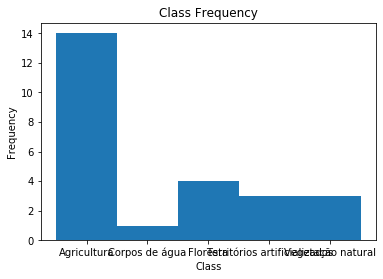

Number of different classes :5
['Agricultura' 'Corpos de água' 'Floresta' 'Territórios artificializados'
 'Vegetação natural']


In [72]:
import matplotlib.pyplot as plt
unique, counts = np.unique(shapefile[Class], return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

print('Number of different classes :'  + str(len(unique)))
print(unique)

In [73]:
band_count = full_dataset.count
transf =  full_dataset.transform
full_dataset_array = img
cutted =full_dataset_array[:, xmin : xmax ,  ymin : ymax ]
cutted_test = full_dataset_array [:, xmin_test : xmax_test ,  ymin_test : ymax_test ]
print(cutted.shape)
cutted_test.shape

(4, 300, 300)


(4, 200, 200)

In [74]:
import numba
from numba import jit,prange

#@jit(parallel=True)  
def setup_cell_noglobals(i,j,xmin,xmax, ymin, ymax , cutted ,transf , band_count,shapefile):
    coordinates = transf * (xmin + i,ymin + j)
    point = Point(coordinates)
    geometry =  shapefile['geometry']
    geometry = geometry[geometry.contains(point)]
    if geometry.size>0 :
        return geometry.index[0]
    else : 
        print("Not found in shapefile")
        return -1

#@jit(parallel=True)        
def setup_X_and_y_noglobals(xmin,xmax, ymin, ymax , cutted ,transf , band_count,shapefile):
    rX = np.array([], dtype=np.int8).reshape(0,band_count) # pixels for training
    ry = np.array([], dtype=np.string_) # labels for training
    for i in range(xmax-xmin):
        print(i)
        for j in range(ymax-ymin):
            result = setup_cell_noglobals(i,j,xmin,xmax, ymin, ymax , cutted ,transf , band_count,shapefile)
            if (result!=-1) : 
                target = shapefile.at[  result ,Class]
                list_x = []
                for band in range(band_count):
                    list_x.append( cutted[band][i][j] )
                x_entry = np.array( list_x )
                rX = np.vstack((rX,  x_entry   ))
                ry = np.append(ry,target)
    return rX,ry

In [75]:
X,y = setup_X_and_y_noglobals(xmin,xmax, ymin, ymax, cutted ,transf , band_count,shapefile)
X_test,y_test = setup_X_and_y_noglobals(xmin_test,xmax_test, ymin_test, ymax_test, cutted_test ,transf , band_count,shapefile)
print(y.shape)
print(y_test.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [76]:
# What are our classification labels?

labels = np.unique( y )
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, classes=labels))

labels_test = np.unique( y_test )
print('The testing data include {n} classes: {classes}\n'.format(n=labels_test.size, classes=labels_test))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

print('Our X_test matrix is sized: {sz}'.format(sz=X_test.shape))
print('Our y_test array is sized: {sz}'.format(sz=y_test.shape))


The training data include 5 classes: ['Agricultura' 'Corpos de água' 'Floresta' 'Territórios artificializados'
 'Vegetação natural']

The testing data include 3 classes: ['Agricultura' 'Corpos de água' 'Territórios artificializados']

Our X matrix is sized: (90000, 4)
Our y array is sized: (90000,)
Our X_test matrix is sized: (40000, 4)
Our y_test array is sized: (40000,)


Text(0.5, 1.0, 'Band Intensities Higher Ref Subset')

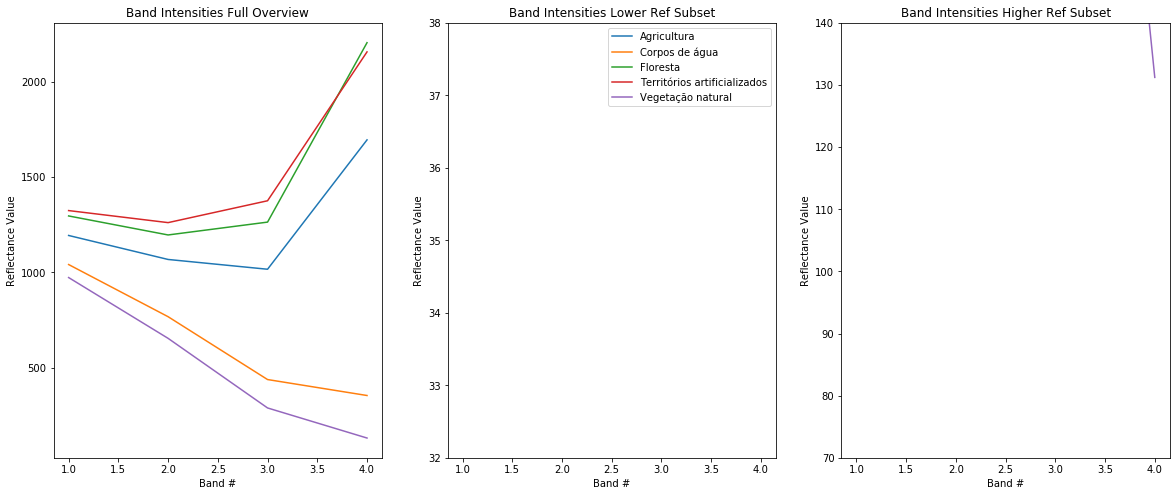

In [77]:
fig, ax = plt.subplots(1,3, figsize=[20,8])

# numbers 1-4
band_count = np.arange(1,5)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)
# plot them as lines

# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
#ax[0].set_ylim(32,38)
ax[1].set_ylim(32,38)
ax[2].set_ylim(70,140)
#ax.set
ax[1].legend(loc="upper right")
# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')

In [78]:
def str_class_to_int(class_array):
    class_array[class_array == 'Territórios artificializados'] = 0
    class_array[class_array == 'Agricultura'] = 1
    class_array[class_array == 'Floresta'] = 2
    class_array[class_array == 'Vegetação natural'] = 3
    class_array[class_array == 'Espaços descobertos ou com vegetação esparsa'] = 4
    class_array[class_array == 'Zonas húmidas'] = 5
    class_array[class_array == 'Corpos de água'] = 6
    return(class_array.astype(int))
def str_class_to_int_v2(class_array,class_test):
    uniques = np.unique(class_array)
    i=0
    for class_name in uniques :
        class_array[class_array == class_name ] = i
        class_test[class_test == class_name ] = i
        i+=1
    return(class_array.astype(int) , class_test.astype(int) ) 

In [79]:
print(np.unique(y))
print(np.unique(y_test))
y = str_class_to_int(y)
y_test = str_class_to_int(y_test)
print(np.unique(y))
print(np.unique(y_test))


['Agricultura' 'Corpos de água' 'Floresta' 'Territórios artificializados'
 'Vegetação natural']
['Agricultura' 'Corpos de água' 'Territórios artificializados']
[0 1 2 3 6]
[0 1 6]


# Supervised Classification Algorithm

In [80]:
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
#model = LinearSVC(C=1,verbose=1)
model = KNeighborsClassifier()
model.fit(X, y)
score = model.score(X_test, y_test)
score

0.311675

In [81]:
class_prediction = model.predict(reshaped_img_test.reshape(-1, 4))
before = class_prediction.shape
# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img_test[:, :, 0].shape)
class_prediction.shape

(200, 200)

In [82]:
real_img = y_test
print(before)
print(real_img.shape)
print(y_test.shape)
# Reshape our classification map back into a 2D matrix so we can visualize it
real_class = real_img.reshape(reshaped_img_test[:, :, 0].shape) #fixme
real_class.shape

(40000,)
(40000,)
(40000,)


(200, 200)

In [83]:
real_class = real_class.astype(int)
print(real_class)
class_prediction = class_prediction.astype(int)
class_prediction

[[6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 6 ... 0 0 0]
 [6 6 6 ... 0 0 0]
 [6 6 6 ... 0 0 0]]


array([[6, 6, 6, ..., 1, 1, 0],
       [6, 6, 6, ..., 1, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       ...,
       [6, 6, 0, ..., 1, 1, 1],
       [6, 6, 6, ..., 0, 1, 1],
       [6, 6, 0, ..., 1, 1, 1]])

# Visualizing results 

In [84]:
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (60, 60, 60, 255)),     # Grey - Territórios artificializados
    (1, (20,230,20, 255)),      # Light Green - Agricultura
    (2, (5, 80, 5, 255)),       # Dark Green - Floresta
    (3, (170, 200, 20, 255)),   # Yellow - Vegetação natural
    (4, (50, 20, 0, 255)),      # Brown - Espaços descobertos ou com vegetação esparsa
    (5, (0, 250, 250, 255)),    # Light Blue - Zonas húmidas
    (6, (0, 0, 200, 255)),      # Dark Blue - Corpos de água
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

In [87]:
def discrete_matshow(data):
    #get discrete colormap
    cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))

C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


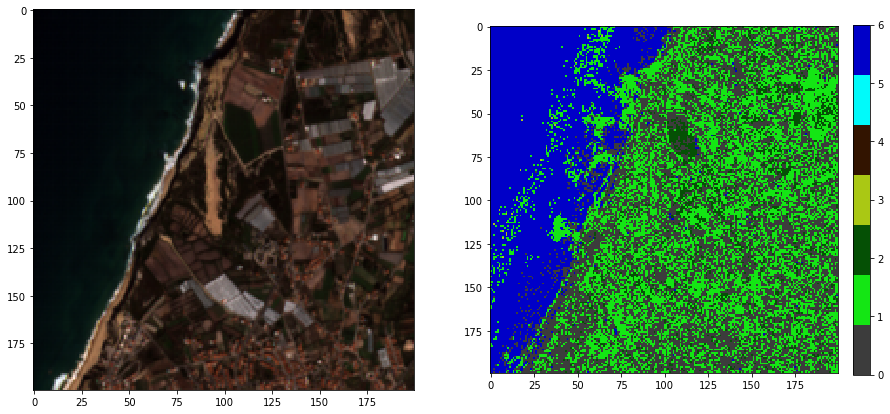

In [104]:

fig, axs = plt.subplots(1,2,figsize=(15,15))


axs[0].imshow(img_stretched_test)

prediction_plot= axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')
fig.colorbar(prediction_plot, ax=axs[1],ticks=range(0,7),fraction=0.046, pad=0.04)

#real_plot = axs[2].imshow(real_class, cmap=cmap, interpolation='none')
#fig.colorbar(real_plot, ax=axs[2],ticks=range(0,6),fraction=0.046, pad=0.04)

fig.show()

C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


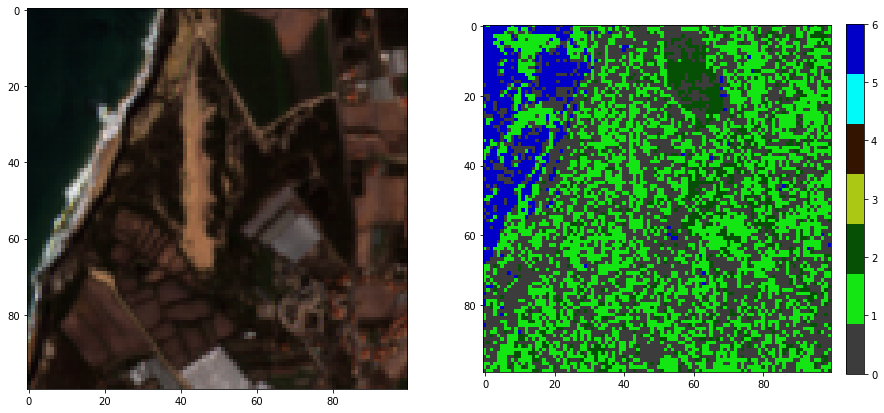

In [109]:
fig, axs = plt.subplots(1,2,figsize=(15,15))

axs[0].imshow(img_stretched_test[50:150, 50:150])
prediction_plot = axs[1].imshow(class_prediction[50:150, 50:150], cmap=cmap, interpolation='none')
fig.colorbar(prediction_plot, ax=axs[1],ticks=range(0,7),fraction=0.046, pad=0.04)
fig.show()


In [90]:
alert() # audio alert



Duration in minutes : 20.00997302 minutes.
